In [1]:
import pandas as pd 
import numpy as np 
import sys
from glob import glob 
import json
import gzip
from tqdm import tqdm 
from pickle import load

data_files = 'models/data/*.gz'
pca_models = 'models/decomp/*.pkl'
iso_pca_models = 'models/pca/*.pkl'
full_model = 'models/reg/*.pkl'


class util(object):
    def __init__(self, files, pca_decomp, iso_models):
        files = glob(files)
        pca_decomposition = glob(pca_decomp)
        iso_models = glob(iso_models)
        
        self.file_names = sorted([f.split('/')[-1].split('.')[0] for f in files])
        self.name_map = {i:j for i, j in enumerate(self.file_names)}
        self.file_path_dict = {x:y for x,y in zip(self.file_names, files)}
        self.pca_models = {x:y for x,y in zip(self.file_names, pca_decomposition)}
        self.iso_models = {x:y for x,y in zip(self.file_names, iso_models)}
        
    def data_load(self, num):
        file = self.file_path_dict[self.name_map[num]]
        with gzip.open(file, 'rb') as f:
            data = pd.read_csv(f, index_col=0)
        return data
    
    def load_pca_model(self, num):
        file = self.pca_models[self.name_map[num]]
        with open(file, 'rb') as f:
            model = load(f)
        return model
        
    def load_iso_model(self, num):
        file = self.iso_models[self.name_map[num]]
        with open(file, 'rb') as f:
            model = load(f)
        return model
        
ut = util(data_files, pca_models, iso_pca_models)
ut.name_map

{0: 'FCU_Control_HeatingReverse',
 1: 'FCU_Control_Unstable',
 2: 'FCU_FanOutletBlockage',
 3: 'FCU_FilterRestriction_10%',
 4: 'FCU_FilterRestriction_20%',
 5: 'FCU_FilterRestriction_50%',
 6: 'FCU_Fouling_Cooling_Airside_Minor',
 7: 'FCU_Fouling_Cooling_Airside_Moderate',
 8: 'FCU_Fouling_Cooling_Airside_Severe',
 9: 'FCU_Fouling_Cooling_Waterside_Minor',
 10: 'FCU_Fouling_Cooling_Waterside_Moderate',
 11: 'FCU_Fouling_Cooling_Waterside_Severe',
 12: 'FCU_Fouling_Heating_Airside_Minor',
 13: 'FCU_Fouling_Heating_Airside_Moderate',
 14: 'FCU_Fouling_Heating_Airside_Severe',
 15: 'FCU_Fouling_Heating_Waterside_Minor',
 16: 'FCU_Fouling_Heating_Waterside_Moderate',
 17: 'FCU_Fouling_Heating_Waterside_Severe',
 18: 'FCU_OABlockage',
 19: 'FCU_OADMPRStuck_0',
 20: 'FCU_OADMPRStuck_100',
 21: 'FCU_OADMPRStuck_30',
 22: 'FCU_OADMPRStuck_50',
 23: 'FCU_OADMPRStuck_80',
 24: 'FCU_SensorBias_RMTemp_+2C',
 25: 'FCU_SensorBias_RMTemp_-2C',
 26: 'FCU_SensorBias_RMTemp_-4C',
 27: 'FCU_VLVLeak_Cool

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA

class setup(util):
    def __init__(self, files, pca_decomp, iso_models):
        super().__init__(files, pca_decomp, iso_models)
        
    def _pca(self, num):
        pca_model = self.load_pca_model(num)
        return pca_model
    
    def _kernel_pca(self, num):
        m = KernelPCA(kernel='rbf')
        return m
        
    def _get_data(self, num=0):
        self.df = self.data_load(num)
        self.X = self.df.drop('FaultCode', axis=1)
        self.feature_names = self.X.columns
        self.X = self._pca(num).transform(self.X.values)
        # self.X = self._kernel_pca(num).fit_transform(self.X)
        self.y = self.df['FaultCode'].apply(lambda x: 0 if x == 0 else 1)
        self._split(self.X, self.y)
        
    def _split(self, X, y, size = .20):
        self.xtrain, self.xtest, self.ytrain, self.ytest = train_test_split(X, y, test_size=size)
                        
    def _iso(self, num):
        iso_model = self.load_iso_model(num)
        return iso_model

    def sload(self, num):
        self._get_data(num)
        clf = self._iso(num)
        clf.fit(self.xtrain, np.where(self.ytrain == 0, 1, -1))
        ypred = np.where(clf.predict(self.xtest) == 1, 0, 1)
        return {'xtest': self.xtest, 'ytrue': self.ytest.values, 'ypred': ypred, 'clf': clf}
    
            
        
s = setup(data_files, pca_models, iso_pca_models)

s.sload(0)

{'xtest': array([[ 55.24298908, -23.07743765,  28.07947324, ..., -17.20762229,
         127.00131546,  -0.75073783],
        [ 41.83936625,  32.68953572,  -9.97712918, ..., -17.20762229,
         127.00131546,  -0.75073783],
        [ 46.78120507, -33.33511467,  44.32229442, ..., -17.20762229,
         127.00131546,  -0.75073783],
        ...,
        [ 57.51455144, -59.50704739,  46.60460354, ..., -17.20762229,
         127.00131546,  -0.75073783],
        [ 40.30485066, -10.58099464,   2.05316687, ..., -17.20762229,
         127.00131546,  -0.75073783],
        [ 52.9854386 , -28.09056741,  25.38896658, ..., -17.20762229,
         127.00131546,  -0.75073783]]),
 'ytrue': array([0, 0, 0, ..., 0, 0, 0]),
 'ypred': array([0, 1, 0, ..., 0, 0, 0]),
 'clf': IsolationForest(bootstrap=True, contamination=0.2, random_state=28)}

In [3]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay


class plot_points(setup):
    def __init__(self, files, pca_decomp, iso_models):
        super().__init__(files, pca_decomp, iso_models)
        
    def ready(self, nums):
        names = [self.name_map[num] for num in nums]
        d = [self.sload(num) for num in nums]
        return {x:y for x,y in zip(names, d)}


p = plot_points(data_files, pca_models, iso_pca_models)
plot_data = p.ready([3, 23, 42])
# plot_data = p.ready([18, 0, 42])


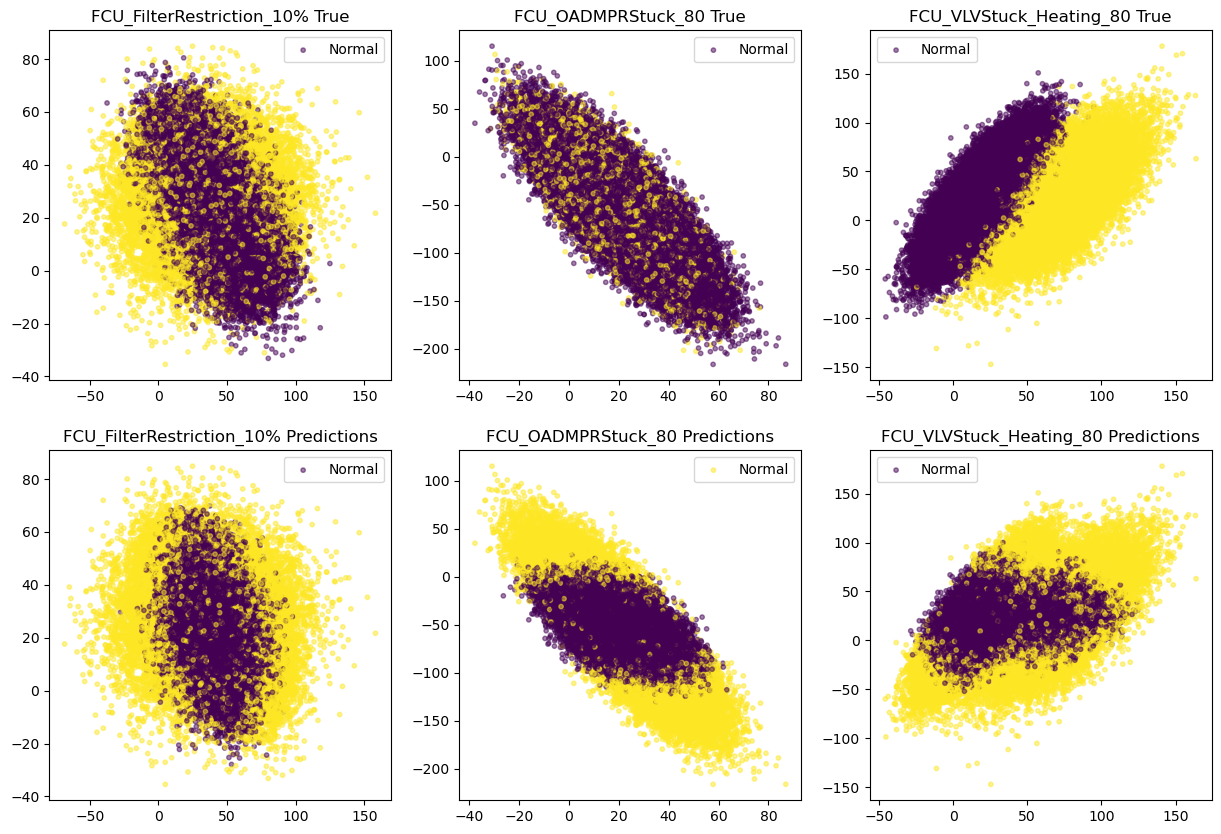

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, (k, v) in enumerate(plot_data.items()):
    ax[0, i%3].scatter(v['xtest'][:,0], v['xtest'][:,1], c=v['ytrue'], cmap='viridis', s=10, alpha=.5)
    ax[1, i%3].scatter(v['xtest'][:,0], v['xtest'][:,1], c=v['ypred'], cmap='viridis', s=10, alpha=.5)
    ax[0, i%3].set_title(k + ' True')
    ax[1, i%3].set_title(k + ' Predictions')
    ax[0, i%3].legend(['Normal', 'Faulty'])
    ax[1, i%3].legend(['Normal', 'Faulty'])

In [5]:
# disp = DecisionBoundaryDisplay.from_estimator(clf,X)
# disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=1, edgecolor="k", alpha=0.4, )
# disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
# plt.show()

# fig, ax = plt.subplots(2, 3, figsize=(15, 10))
# choose 3 models, plot the the predicted label, and actual labels over the decision boundary 
# ms = [d[names[0]], d[names[1]], d[names[2]]]

# for i, clf in enumerate(ms):
#     # disp = DecisionBoundaryDisplay.from_estimator(clf,clf.X, ax=ax[0, i])
#     # disp.ax_.scatter(clf.X[:, 0], clf.X[:, 1], c=clf.y, s=1, edgecolor="k", alpha=0.4, )
#     # disp.ax_.set_title(f"Observed Labels\nof {names[i]}")
#     ax[0, i].scatter(clf.X[:, 0], clf.X[:, 1], c=clf.y, s=1, alpha=0.8, )
#     ax[0, i].set_title(f"Observed Labels\nof {names[i]}")
    

#     # plot the predicted labels
#     y_pred = clf.predict(clf.X)
#     ax[1, i].scatter(clf.X[:, 0], clf.X[:, 1], c=y_pred, s=1, alpha=0.8, )
#     ax[1, i].set_title(f"Predicted labels of\n{names[i]}")